In [38]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [39]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
from standardization_process import plot_reg_correlation,plot_diagram,unreliable_datapoints,plot_cls_correlation
from data_split import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
def remove_bad_datapoints(df,controlled_list,value_col,fold=np.log10(3)):
    bad_datapoints_index = unreliable_datapoints(df, controlled_list, value_col)
    df = df.loc[~df.index.isin(bad_datapoints_index),] 
    
    bad_group_index = identify_unreliable_group(df, controlled_list, value_col, fold=fold)
    
    df = df.loc[~df.index.isin(bad_group_index),] 
    
    
    return df

In [41]:
def compound_property_analysis(mol_list):
    atom_counts = mol_list.map(lambda x: x.GetNumAtoms())
    qed = mol_list.parallel_apply(Descriptors.qed)
    logp = mol_list.parallel_apply(Descriptors.MolLogP)
    TPSA = mol_list.parallel_apply(Descriptors.TPSA)
    HBD = mol_list.parallel_apply(Descriptors.NumHDonors)
    HBA = mol_list.parallel_apply(Descriptors.NumHAcceptors)
    
    fig, axs = plt.subplots(3,2, figsize=(16, 10))

    # Plot data
    axs[0, 0].hist(qed, bins=20, color='b', alpha=0.7, label='A')
    axs[0, 0].set_title('qed')

    axs[0, 1].hist(atom_counts, bins=20, color='r', alpha=0.7, label='B')
    axs[0, 1].set_title('atom_counts')

    axs[1, 0].hist(logp, bins=20, color='g', alpha=0.7, label='C')
    axs[1, 0].set_title('logp')

    axs[1, 1].hist(TPSA, bins=20, color='y', alpha=0.7, label='D')
    axs[1, 1].set_title('TPSA')

    axs[2, 0].hist(HBD, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 0].set_title('HBD')

    axs[2, 1].hist(HBA, bins=20, color='y', alpha=0.7, label='D')
    axs[2, 1].set_title('HBA')

    # Add some labels and titles for better readability
    for ax in axs.flat:
        ax.set( ylabel='Frequency')


    plt.show()

# Load data

In [8]:
all_data = pd.read_csv('../data/data_processing_result/ames_preprocessing_finished.csv')

In [9]:
all_data.head()

,Smiles_unify,Smiles,value,source,property,cell_type,s9
0,[N-]=[N+]=C1C=NC(=O)NC1=O,[N-]=[N+]=C1C=NC(=O)NC1=O,1,Benchmark,ames,NaN,-1
1,Cc1cccc([N+](=O)[O-])c1C,Cc1cccc([N+](=O)[O-])c1C,1,Benchmark,ames,NaN,-1
2,OC1C=Cc2c(ccc3c(Br)c4ccccc4cc23)C1O,OC1C=Cc2c(ccc3c(Br)c4ccccc4cc23)C1O,1,Benchmark,ames,NaN,-1
3,Cc1cc2c(nc(N)n2C)c2ncc(-c3ccccc3)nc12,Cc1cc2c(nc(N)n2C)c2ncc(-c3ccccc3)nc12,1,Benchmark,ames,NaN,-1
4,Oc1cc2c3ccccc3ccc2c2ccccc12,Oc1cc2c3ccccc3ccc2c2ccccc12,1,Benchmark,ames,NaN,-1


<AxesSubplot:>

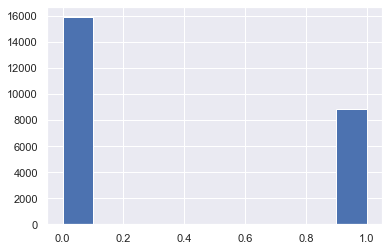

In [10]:
all_data['value'].hist()

### analysis duplicated

In [11]:
all_data['source1'] = all_data['source'].apply(lambda x: x if x in ['EFSA','Xu','Benchmark','ECVA'] else 'Chembl')

In [12]:
all_data['source'].value_counts()

EFSA             7294
Xu               7278
Benchmark        6498
ECVA             1293
CHEMBL2210499      30
                 ... 
CHEMBL1251165       1
CHEMBL1120177       1
CHEMBL2410272       1
CHEMBL1685383       1
CHEMBL5217974       1
Name: source, Length: 647, dtype: int64

In [13]:
all_data['cell_type'] = all_data['cell_type'].fillna('unknown')

In [14]:
df  = all_data.drop_duplicates(['Smiles_unify','s9','source1'])
df_pivot = pd.pivot_table(data=df, index=['Smiles_unify','s9'], columns='source1', values='value')
df_pivot.reset_index(inplace=True)

In [15]:
df_pivot[(~df_pivot['ECVA'].isna()) & (~df_pivot['Chembl'].isna())]

source1,Smiles_unify,s9,Benchmark,Chembl,ECVA,EFSA,Xu
2032,CC1CS(=O)(=O)CCN1/N=C/c1ccc([N+](=O)[O-])o1,0,NaN,1.0,1.0,NaN,NaN
2033,CC1CS(=O)(=O)CCN1/N=C/c1ccc([N+](=O)[O-])o1,1,NaN,1.0,1.0,NaN,NaN
2817,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,0,NaN,0.0,1.0,NaN,NaN
2888,CCN(CCCl)CCCNc1c2ccc(Cl)cc2nc2ccc(OC)cc12,0,NaN,1.0,1.0,NaN,NaN
6185,Cc1cccc(C)c1N,0,NaN,0.0,1.0,0.0,NaN
7643,Nc1ccc(-c2ccc(Cl)cc2)cc1,0,NaN,0.0,1.0,NaN,NaN
8273,O=C(Cn1ccnc1[N+](=O)[O-])NCc1ccccc1,0,NaN,1.0,1.0,NaN,NaN
9248,O=NN1CCCC1,0,NaN,0.0,1.0,NaN,NaN
9589,O=[N+]([O-])c1cc[n+]([O-])c2ccccc12,0,NaN,1.0,1.0,NaN,NaN
9590,O=[N+]([O-])c1cc[n+]([O-])c2ccccc12,1,NaN,1.0,1.0,NaN,NaN


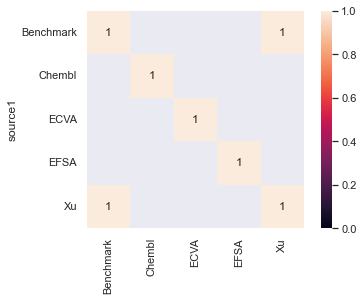

In [16]:
# tmp = all_data.drop_duplicates(['Smiles_unify','source1'])
plot_cls_correlation(all_data, ['Smiles_unify','cell_type','s9'], 'source1', 'value', fig_title='datasets correlation')

# Process

In [17]:
all_data['Smiles'].nunique()

9200

In [18]:
ames_cls = pd.DataFrame()
ames_cls['value'] = all_data.groupby(['Smiles_unify']).apply(lambda x: max(x['value']))

In [19]:
ames_cls

,value
Smiles_unify,
Br/C=C/Br,1
BrC(Br)Br,1
BrC(Br)C(Br)(Br)Br,0
BrC(Br)C(Br)Br,0
BrC/C=C\CBr,1
...,...
c1csc(-c2nc(N3CCOCC3)c3ccccc3n2)c1,1
c1cscn1,1
c1nc[nH]n1,0


In [20]:
ames_cls['property'] = 'ames'

In [21]:
ames_cls = ames_cls.reset_index()

In [31]:
df = ames_cls[['Smiles_unify','value','property']]

# Compound Property analysis 

In [32]:
mol_list = df['Smiles_unify'].map(Chem.MolFromSmiles)

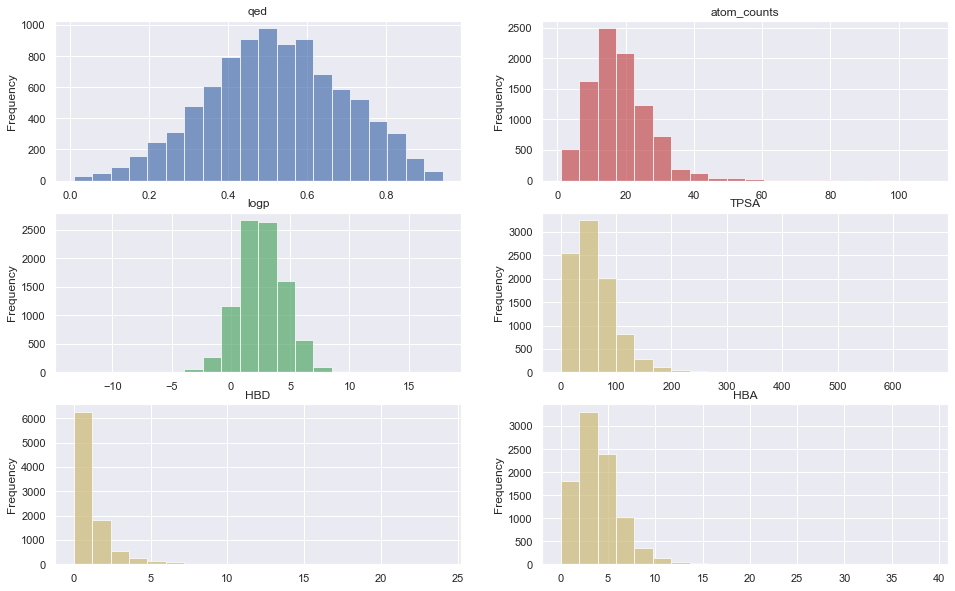

In [33]:
compound_property_analysis(mol_list)

# Data Split

In [34]:
train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=True)
df.loc[train_index,'scaffold_train_test_label'] = 'train'
df.loc[test_index,'scaffold_train_test_label'] = 'test'

100%|█████████████████████████████████████████| 9139/9139 [00:01<00:00, 7324.11it/s]


In [35]:
train_index,test_index = train_test_split(df['Smiles_unify'].map(Chem.MolFromSmiles),split_scaffold=False)
df.loc[train_index,'random_train_test_label'] = 'train'
df.loc[test_index,'random_train_test_label'] = 'test'

100%|████████████████████████████████████████| 9139/9139 [00:00<00:00, 17929.74it/s]


In [36]:
df

,Smiles_unify,value,property,scaffold_train_test_label,random_train_test_label
0,Br/C=C/Br,1,ames,train,train
1,BrC(Br)Br,1,ames,train,train
2,BrC(Br)C(Br)(Br)Br,0,ames,train,train
3,BrC(Br)C(Br)Br,0,ames,train,train
4,BrC/C=C\CBr,1,ames,train,train
...,...,...,...,...,...
9134,c1csc(-c2nc(N3CCOCC3)c3ccccc3n2)c1,1,ames,test,test
9135,c1cscn1,1,ames,train,test
9136,c1nc[nH]n1,0,ames,train,train
9137,c1scc2c1-c1cscc1C1NC21,1,ames,train,test


In [37]:
df.to_csv('../data/final_datasets/ames_cls_final_data.csv',index=False)